# Predicting Languages with READMEs

Rajaram Gautam   
Mason Sherbondy   
Sophia Stewart   
Joshua Wheeler

February 11, 2022

---
## Executive Summary
The goal of this project is to determine what language is primarily used in a repository based only on the contents of that repository's README file. We web scraped the repo name, programming language, and README contents from 230 repositories on GitHub. Using a Logistic Regression model, we were able to achieve 13.5% accuracy in our predictions, beating the baseline.

---
## Data Wrangling

We decided to use repositories that came up in a GitHub search for the word 'zombie'. We acquired the data using Zach Gulde's functions for acquiring data using GitHub's API as well as some functions defined by our group to acquire the names of the repositories. To prepare our data, we removed those repositories which had non-English characters. We then normalized, tokenized, stemmed, lemmatized, and removed stopwords from each README. Before moving on to our data exploration, we split our dataset into train, validate, and test samples.

In [1]:
from acquire import get_df
from prepare import remove_stopwords, prep_repo_data, split_data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import explore


import warnings
warnings.filterwarnings("ignore")

In [2]:
# retrieve dataframe from acquire
df = get_df()

# prepare df
df = prep_repo_data(df)

# split data
train, validate, test = split_data(df)

# add exploration columns
df, train, validate, test = explore.explore(df,train,validate,test)

## Exploratory Data Analysis

### Question 1: What is the distribution of our Inverse Document Frequencies for the most common words?

IDF Distributions for Top 6 Occuring Words


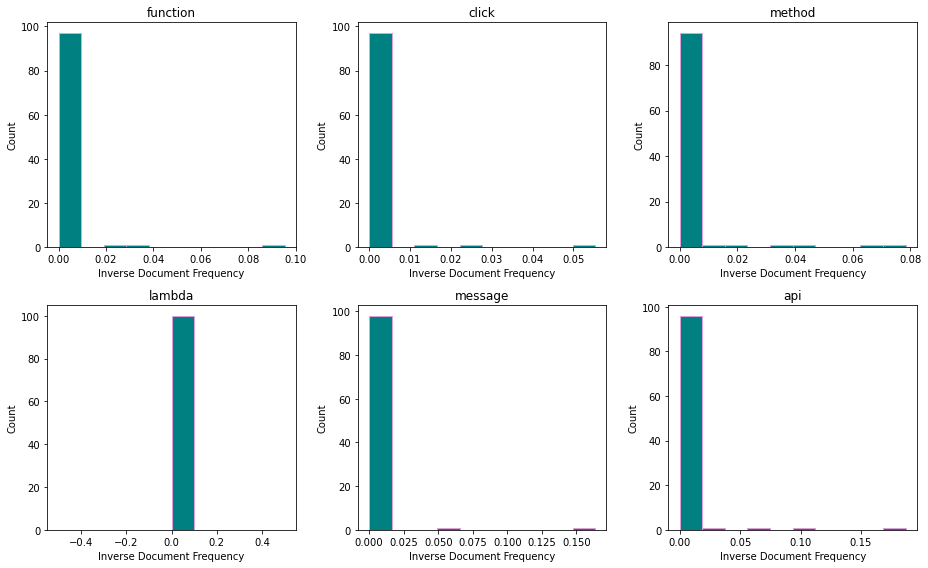

In [3]:
# get idf distributions
dist = explore.get_idf_dist(train)
explore.distributions_grid(train, dist[:6])
print('IDF Distributions for Top 6 Occuring Words')

### Answer 1: The majority of our top words do not have a distribution that is helpful, as most of these values are 0.
---

### Question 2: Does the length of the README vary by programming language?

#### $H_{0}$: Average message length for languages is about the same.
#### $H_{a}$: Average message length between languages is significantly different.

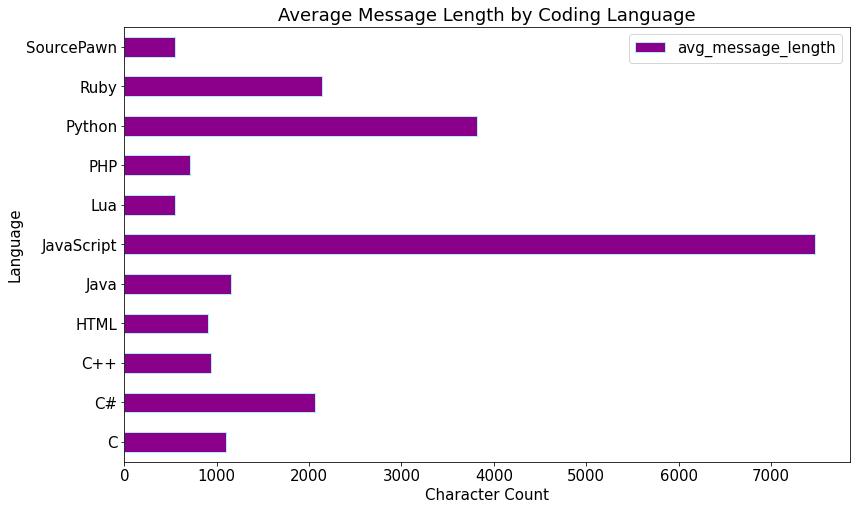

In [4]:
explore.bar_messages(train)

In [5]:
# run kruskal-wallis test for README length
explore.run_kruskal_wallis(train)

17.512468712338894 0.0637659665132073


'Reject the null hypothesis.'

### Answer 2: There is a significant difference in average message length between languages.
---
### Question 3: Do different programming languages use a different number of unique words?

Words most frequently appearing for one language over the others:
- Javascript: AWS, stack, response, topic, gateway, endpoint  
- HTML: integration, workshop, **h1, align,** center, homepage, firefox, implementation  
- C#: learning, watching, factor, pickup, animation, fire (maybe used more for modding)  
- PHP: addition, kevin, bundle (not too many in training set)  
- C: victim, variant, linux, letter, cpu(also used a lot in ruby), memory, block, **sudo** (potentially also more used for video game mods)
- SourcePawn: plugins, csgo(name of game), bos, force, sourcemod  
- C++: online (not many repos)  
- Java: door, plant, sun, storage, private, endpoint, **maven** (likely used for modding)
- Python: given, shotgun, exists, specified, dictionary, codeblock, allowed  
- Lua: plague, gamemode, language, infection (game mods)  
- Ruby: rail, rake, generated, report, csv(?), paragraph, parse

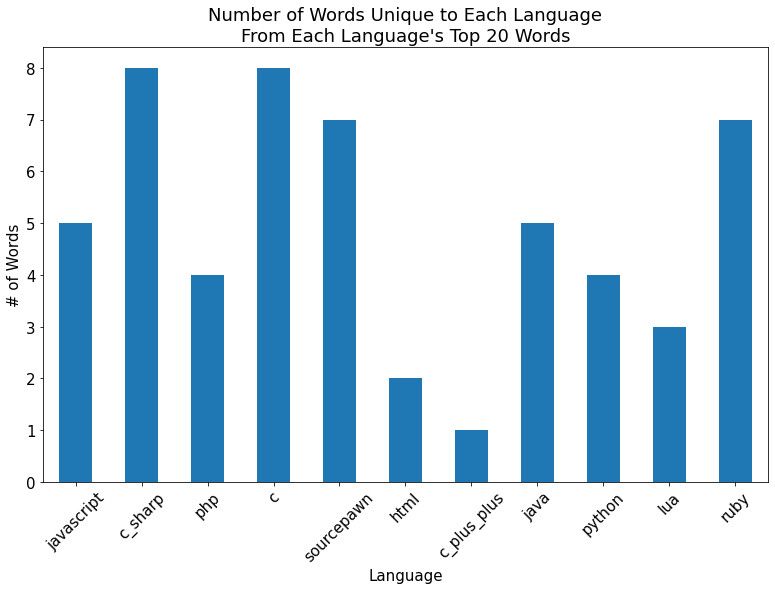

In [6]:
# visualize unique word count by language
explore.unique_word_viz(train)

### Answer 3: Yes, different programming languages use a different number of unique words.
---
### Question 4: Does sentiment score vary by programming language?

#### $H_{0}$: Average sentiment for languages is about the same.
#### $H_{a}$: Average sentiment between languages is significantly different.

In [7]:
# run kruskal-wallis test for sentiment score
explore.run_kruskal_wallis_sentiment(train)

24.61091502485974 0.0061338790014197776


'Reject the null hypothesis.'

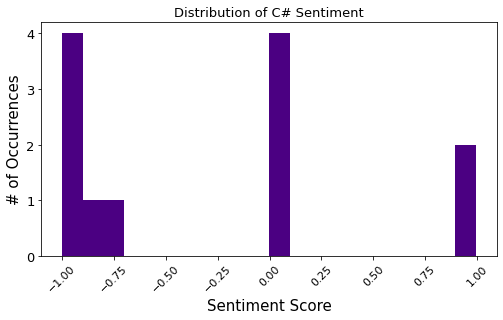

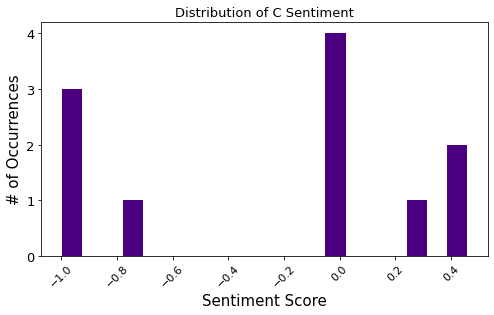

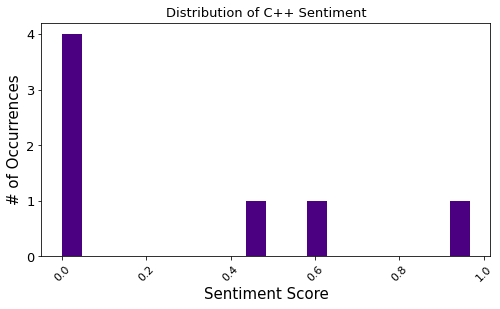

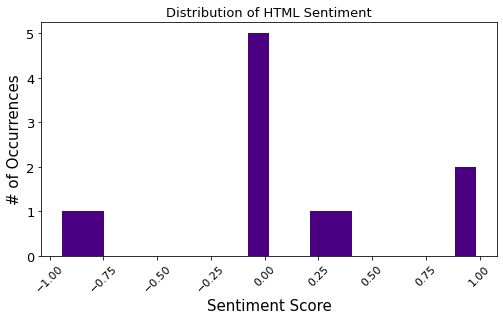

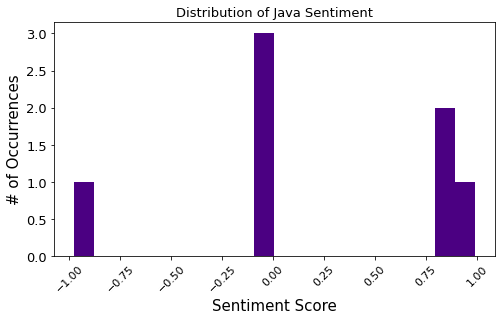

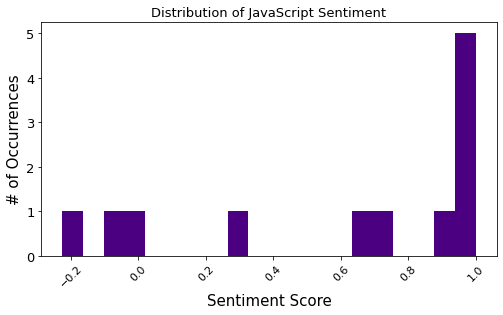

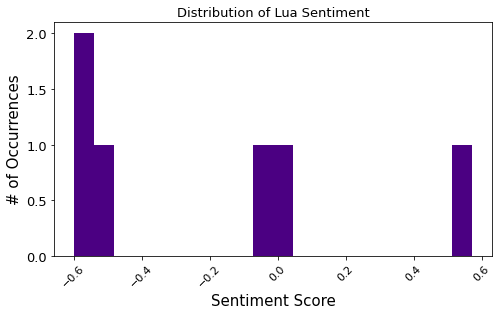

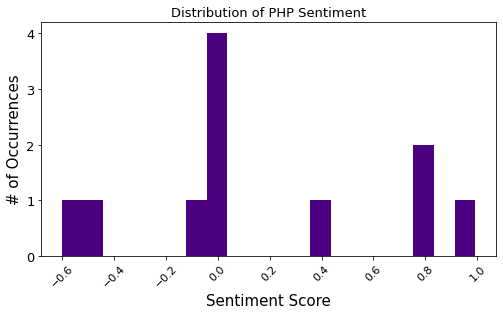

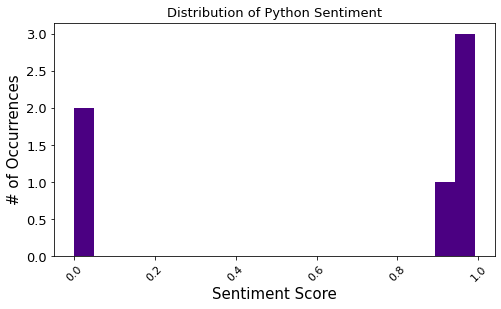

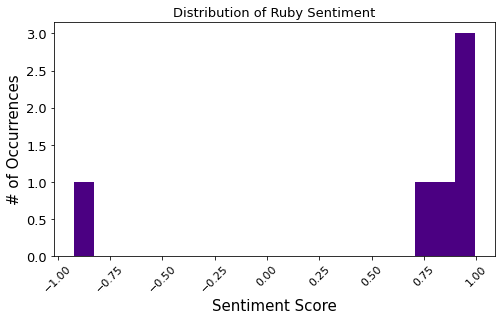

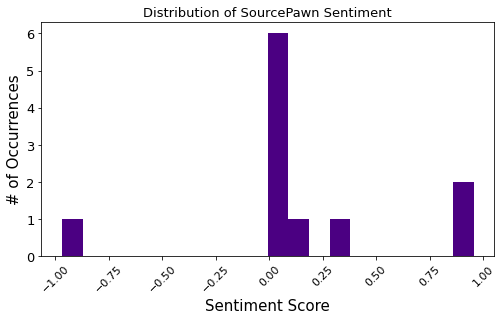

In [8]:
# visualize sentiment distributions by language
explore.sentiment_viz(train)

### Answer 4: Yes, there is a significant difference in sentiment score based on programming language.
---
### Data Exploration Takeaways:

- Some of the languages included in our dataset appear to be used primarily for game modding.
- Looking at the distribution of frequently occurring words was not helpful.
- Not all languages had most frequently occurring words that were unique to only that language, but most did.
- There was a significant amount of variation in the length of the README files based on what language they were primarily comprised of.
- There was a significant amount of variation in sentiment based on programming language.

---
## Modeling

For our baseline prediction, we decided to use JavaScript. We made this decision because JavaScript appears most frequently in our dataset, along with C#.

For all of our models, the features we included were TF-IDF, word count, and character count.

In [9]:
# Import evaluation metrics
from sklearn.metrics import classification_report, accuracy_score

# Create list of features
features = train.drop(columns = ['repo','coding_language','readme_contents','repo_link','cleaned_readme','stemmed','lemmatized', 'sentiment']).columns.to_list()

# Define X and y for train, validate, and test
X_train =  train[features]
y_train =  train.coding_language
X_validate = validate[features]
y_validate = validate.coding_language
X_test = test[features]
y_test = test.coding_language

### Baseline
- Always predict JavaScript

In [10]:
# establish baseline
train['modeling_baseline'] = 'JavaScript'
validate['modeling_baseline'] = 'JavaScript'
test['modeling_baseline'] = 'JavaScript'

# print results
print('Train Accuracy: {:.2%}'.format(accuracy_score(train.coding_language, train.modeling_baseline)))
print('\nValidate Accuracy: {:.2%}'.format(accuracy_score(validate.coding_language, validate.modeling_baseline)))


Train Accuracy: 12.00%

Validate Accuracy: 13.64%


### Model 1: Logistic Regression
- Default hyperparameters

In [11]:
# import model
from sklearn.linear_model import LogisticRegression
# Create and fit object
lm = LogisticRegression().fit(X_train, y_train)

# predict for train and validate
train['predicted_lm']= lm.predict(X_train)
validate['predicted_lm'] = lm.predict(X_validate)

# print results
print('Train Accuracy: {:.2%}'.format(accuracy_score(train.coding_language, train.predicted_lm)))

print('\nValidate Accuracy: {:.2%}'.format(accuracy_score(validate.coding_language, validate.predicted_lm)))


Train Accuracy: 23.00%

Validate Accuracy: 20.45%


### Model 2: Random Forest
- max_depth = 5

In [12]:
# import model
from sklearn.ensemble import RandomForestClassifier
# create random forest object
rf = RandomForestClassifier(min_samples_leaf=3,criterion='gini',max_depth=5,random_state=222)

# fit model
rf.fit(X_train, y_train)

# predict on train and validate
train['predicted_rf'] = rf.predict(X_train)
validate['predicted_rf'] = rf.predict(X_validate)

# print results
print('Train Accuracy: {:.2%}'.format(accuracy_score(train.coding_language, train.predicted_rf)))
print('\nValidate Accuracy: {:.2%}'.format(accuracy_score(validate.coding_language, validate.predicted_rf)))

Train Accuracy: 28.00%

Validate Accuracy: 13.64%


### Model 3: Decision Tree
- max_depth = 5

In [13]:
# import model
from sklearn.tree import DecisionTreeClassifier
# create decision tree object
clf = DecisionTreeClassifier(max_depth = 5, random_state = 222)
# fit object
clf = clf.fit(X_train, y_train)

# predict on train and validate
train['predicted_clf'] = clf.predict(X_train)
validate['predicted_clf'] = clf.predict(X_validate)

# print results
print('Train Accuracy: {:.2%}'.format(accuracy_score(train.coding_language, train.predicted_clf)))
print('\nValidate Accuracy: {:.2%}'.format(accuracy_score(validate.coding_language, validate.predicted_clf)))

Train Accuracy: 31.00%

Validate Accuracy: 9.09%


### Takeaways:
- Our Decision Tree model was clearly overfit as it performed better than any other model on train but it had extremely poor performance on validate.
- Both of our other models also performed better on train than validate but our Logistic Regression model seemed to be the least overfit as there was less of a difference in accuracy between train and validate.
- The Logistic Regression model performed best on the validate sample
- Based on the result of the statistical test regarding sentiment score, we initially included sentiment score in the feaures we fed into the model. However, our models performed better on out-of-sample data without including sentiment as a feature in the models.
- **Our best model is the Logistic Regression model**

### Evaluating the Best Model on Test

Since the Logistic Regression model performed best overall, we ran this model on the test sample and compared it to the baseline prediction.

In [14]:
# run model on baseline
test['predicted_lm']= lm.predict(X_test)
test['predicted_baseline']= 'JavaScript'

# print results
print('Baseline Accuracy: {:.2%}'.format(accuracy_score(test.coding_language, test.predicted_baseline)))
print('Linear Regression Model Accuracy: {:.2%}'.format(accuracy_score(test.coding_language, test.predicted_lm)))


Baseline Accuracy: 10.81%
Linear Regression Model Accuracy: 13.51%


---
## Conclusion

The combination of machine learning and zombie-related repositories did not provide for very useful predictions. With a Logistic Regression model, we were able to achieve 13.5% accuracy in our predictions on unseen data. While this did beat the baseline, we know it could be greatly improved.

### Next Steps
With more time we would like to train our models using more repositories with a greater variety of subjects.